# 1. Business Problem


Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it's ready to ship. 

Today, Severstal is leading the charge in efficient steel mining and production. Severstal is now looking for machine learning to identify defects in steel which will help make production of steel more efficient. This competition will help engineers improve the defect detection algorithm by localizing and classifying surface defects on a steel sheet.

# 2. Source of Data

It is a Kaggle competition held by Severstal. 

https://www.severstal.com/eng/

Data is available at  https://www.kaggle.com/c/severstal-steel-defect-detection

# 3. Data Overview

* train_images/ - folder with 12568 .jpg training images.

* test_images/ - folder with 5516 .jpg test images (we are segmenting and classifying these images).

* train.csv - training annotations which provide segments for defects with total 4 defect classes (ClassId=[1,2,3,4]).

* sample_submission.csv - a sample submission file in the correct format (for each ImageId 4 rows, one for each of the 4 defect classes).

* Each image is of 256x1600 resolution

#4. Mapping real world problem with Deep Learning problem

#4.1. Image Segmentation

Image segmentation is the process of partitioning a digital image into multiple segments. A segmentation model returns much more detailed information about the image. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.



The Different Types of Image Segmentation

A) Semantic Segmentation

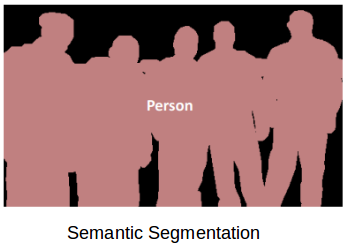

Every pixel belongs to a particular class(either background or person). Also, all the pixels belonging to a particular class are represented by the same color (background as black and person as pink). This is an example of semantic segmentation.

B) Instance Segmentation

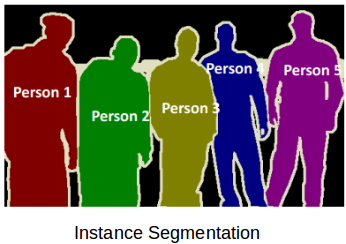

Here also assigned a particular class to each pixel of the image. However, different objects of the same class have different colors (Person 1 as red, Person 2 as green, background as black, etc.). This is an example of instance segmentation

**In Steel defect detection we will go for Semantic Segmentation.**

#4.2. Encoded Pixels

In order to reduce the submission file size, metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for segmentation, I will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

# 5. Performance Metrics

The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth.

The formula is given by:

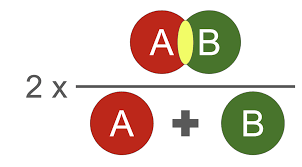

where A is the predicted set of pixels and B is the ground truth. The Dice coefficient is defined to be 1 when both A and B are empty.

#6. Objective

Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image one must segment defects of each class (ClassId = [1,2,3,4]).

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import matplotlib.patches as patches
import re
import random 
import pickle
import cv2
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#7. EDA & Data Preparation

In [ ]:
train_csv=pd.read_csv('/content/drive//My Drive/Steel_Detection /train.csv')
train_csv.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
train_csv.shape

(7095, 3)

In [ ]:
Image_id=[]
label=[]
train_folder_path='/content/drive//My Drive/Steel_Detection /train_images'
for i in os.listdir(train_folder_path): #https://www.geeksforgeeks.org/python-os-listdir-method/
    for j in range(1,5):
        Image_id.append(i)
        label.append(j)

x={'ImageId':Image_id,'ClassId':label}  #https://www.geeksforgeeks.org/creating-a-pandas-dataframe/
train_img=pd.DataFrame(x)
train_img.head(10)

,ImageId,ClassId
0,eb5aec756.jpg,1
1,eb5aec756.jpg,2
2,eb5aec756.jpg,3
3,eb5aec756.jpg,4
4,e9b77950e.jpg,1
5,e9b77950e.jpg,2
6,e9b77950e.jpg,3
7,e9b77950e.jpg,4
8,eb7ec1f85.jpg,1
9,eb7ec1f85.jpg,2


In [ ]:
#https://www.geeksforgeeks.org/python-get-unique-values-list/
image_size=set()
train_folder_path='/content/drive//My Drive/Steel_Detection /train_images'
for i in os.listdir(train_folder_path): #https://www.geeksforgeeks.org/python-os-listdir-method/
  image_size.add(cv2.imread(train_folder_path+'/'+i).shape)
unique_image=list(image_size)
for x in unique_image:
  print (x)

(256, 1600, 3)


* Each image is of 256x1600 resolution

In [ ]:
#https://stackoverflow.com/questions/53645882/pandas-merging-10
df=pd.merge(train_img,train_csv,how='outer',on=['ImageId','ClassId'])
df.fillna('',inplace=True)
df.head()

,ImageId,ClassId,EncodedPixels
0,eb5aec756.jpg,1,
1,eb5aec756.jpg,2,
2,eb5aec756.jpg,3,
3,eb5aec756.jpg,4,
4,e9b77950e.jpg,1,378485 4 378733 13 378985 18 379241 18 379496 ...


In [ ]:
#https://www.analyticsvidhya.com/blog/2020/03/pivot-table-pandas-python/
train=pd.pivot_table(df,values='EncodedPixels',index='ImageId',columns='ClassId',aggfunc=np.sum).astype(str)
train=train.reset_index()
train.columns=['image_id','rle_1','rle_2','rle_3','rle_4'] 
train.head()

,image_id,rle_1,rle_2,rle_3,rle_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [ ]:
#Stratified corrosion is a type of corrosion that progresses parallel to the metal surface in such a manner that underlying layers are gradually separated.
#For stratified sampling, we have taken stratified based on minority label priority
#https://economictimes.indiatimes.com/definition/stratified-sampling
defect=[]
stratify=[]
for i in range(len(train)):
  if (train['rle_1'][i] != '' or train['rle_2'][i] != '' or train['rle_3'][i] != '' or train['rle_4'][i] != ''):
    defect.append(1)
  else:
    defect.append(0)
  
  if train['rle_1'][i] != '':
    stratify.append(1)
  elif train['rle_2'][i] != '':
    stratify.append(2)
  elif train['rle_3'][i] != '':
    stratify.append(3)
  elif train['rle_4'][i] != '':
    stratify.append(4)
  else:
    stratify.append(0)
train['defect']=defect
train['stratify']=stratify

In [ ]:
train.head()

,image_id,rle_1,rle_2,rle_3,rle_4,defect,stratify
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1
1,00031f466.jpg,,,,,0,0
2,000418bfc.jpg,,,,,0,0
3,000789191.jpg,,,,,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,3


In [ ]:
defect_1,defect_2,defect_3,defect_4=[],[],[],[]
for i in range(len(train)):
  if train['rle_1'][i] != '':
    defect_1.append(1)
  else:
    defect_1.append(0)
  if train['rle_2'][i] != '':
    defect_2.append(1)
  else:
    defect_2.append(0)
  if train['rle_3'][i] != '':
    defect_3.append(1)
  else:
    defect_3.append(0)
  if train['rle_4'][i] != '':
    defect_4.append(1)
  else:
    defect_4.append(0)
train['defect_1']=defect_1
train['defect_2']=defect_2
train['defect_3']=defect_3
train['defect_4']=defect_4
train['total_defects']=train['defect_1']+ train['defect_2']+ train['defect_3']+ train['defect_4']
train.head()

,image_id,rle_1,rle_2,rle_3,rle_4,defect,stratify,defect_1,defect_2,defect_3,defect_4,total_defects
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,1,0,0,0,1
1,00031f466.jpg,,,,,0,0,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,3,0,0,1,0,1


In [ ]:
train.shape

(12568, 12)

In [ ]:
with open('/content/drive//My Drive/Steel_Detection /data.pkl','wb') as f:
     pickle.dump(train,f)

In [ ]:
test_image=[i for i in os.listdir('/content/drive//My Drive/Steel_Detection /test_images')]

In [ ]:
len(test_image)

5516

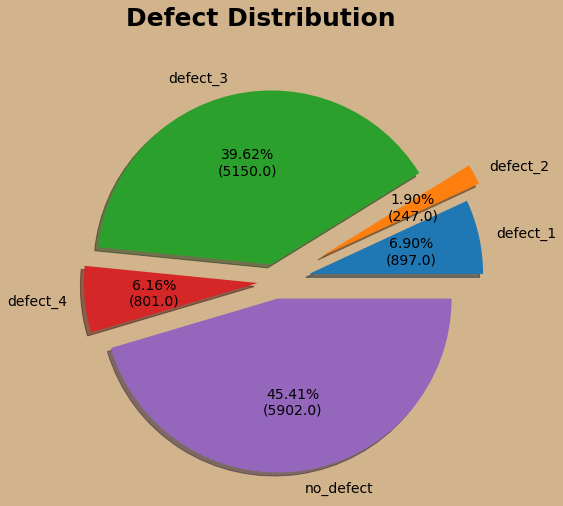

In [ ]:
#https://www.askpython.com/python/plot-customize-pie-chart-in-python
defect_1,defect_2,defect_3,defect_4,no_defect=0,0,0,0,0
def func(v,p): #https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
  a=p*sum(v)/100
  return "{:.2f}%\n({:.1f})".format(p,a)
for i in range(len(train)):
  if train['rle_1'][i] != '':
    defect_1+=1
  if train['rle_2'][i] != '':
    defect_2+=1
  if train['rle_3'][i] != '':
    defect_3+=1
  if train['rle_4'][i] != '':
    defect_4+=1
  if train['defect'][i] == 0:
    no_defect+=1
labels=['defect_1','defect_2','defect_3','defect_4','no_defect']
sizes=[defect_1,defect_2,defect_3,defect_4,no_defect]
explode=(0.2,0.3,0.1,0.1,0.1)
fig,ax=plt.subplots(figsize=(16,8))
ax.pie(sizes,explode=explode,labels=labels,textprops={'fontsize': 14},autopct=lambda p: func(sizes,p),shadow=True)
fig.suptitle('Defect Distribution',fontsize=25,fontweight='bold')
fig.set_facecolor("tan")
plt.show()

* The dataset is very imbalanced.

* Data augmentation and resampling techniques will be required to perform the defect detection.

In [ ]:
def patch1(bar,ax):
  #https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
  for p in bar.patches: 
     width=p.get_width()
     height=p.get_height()
     x,y=p.get_xy() 
     ax.annotate('{}'.format(height),(x+width/2,y+height*1.02),ha='center',fontsize=14)

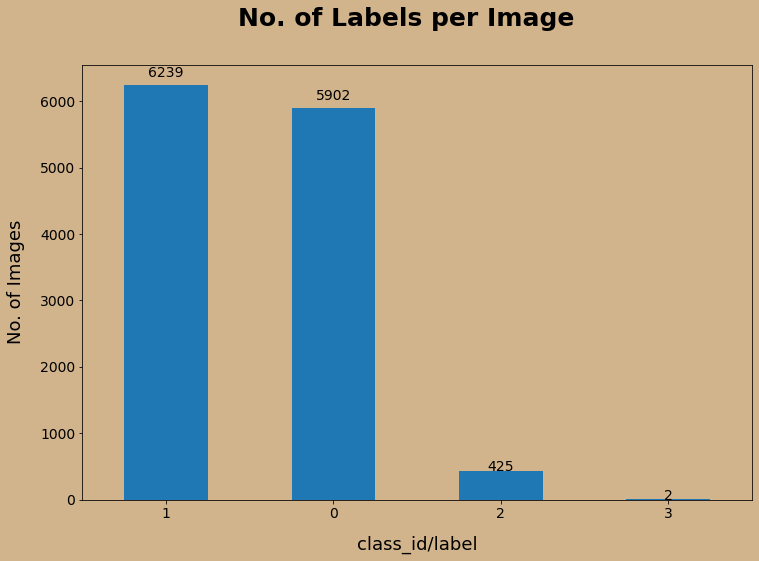

In [ ]:
fig,ax=plt.subplots(figsize=(12,8))
a=train['total_defects'].value_counts().plot(kind='bar')
patch1(a,ax) 
ax.set_xlabel("class_id/label",fontsize=18,labelpad=15)
ax.set_ylabel("No. of Images",fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
fig.suptitle('No. of Labels per Image',fontsize=25,fontweight='bold')
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

* There are 5902 images with no labels

* There are 6239 images with 1 label

* There are 425 images with 2 labels

* There are 2 images with 3 labels

* Almost half of images doesn't contain any defects

* Most of images with defects contain the defects of only one type

* In rare cases an image contains the defects of two different types.

In [ ]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle_to_mask(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle=='')|(rle=='-1'): 
        return np.zeros((256,1600) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])]=1
    
    return mask.reshape((height,width),order='F')

In [ ]:
def plot_mask(rle_defect,k):
  x=rle_defect.columns[2]
  train_folder_path='/content/drive//My Drive/Steel_Detection /train_images/'
  # Create figure and axes
  fig,ax=plt.subplots(4,2,figsize=(14,9))
  fig.suptitle('Defect_'+str(k)+'_Images',fontsize=20,fontweight='bold')
  for i in range(4):
    image_id=rle_defect['image_id'][i]
    rle=rle_defect[x][i]
    im=Image.open(train_folder_path+str(image_id))
    ax[i,0].imshow(im)
    ax[i,0].set_title(image_id)
    mask=rle_to_mask(rle)
    ax[i,1].imshow(mask)
    ax[i,1].set_title("Mask for "+str(image_id))
  fig.set_facecolor("tan")
  plt.show()

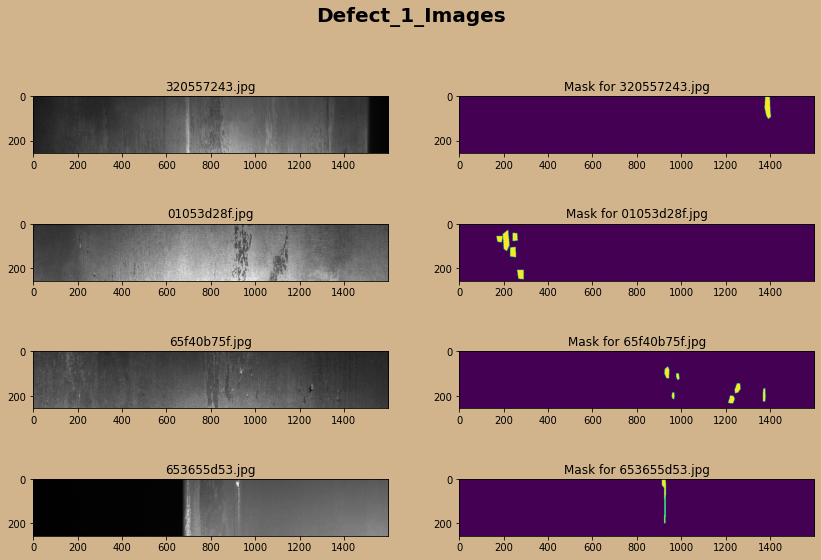

In [ ]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_1']==1]
rle_defect=rle_defect[['image_id','rle_1']]
rle_defect=rle_defect.sample(n=4) 
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,1)

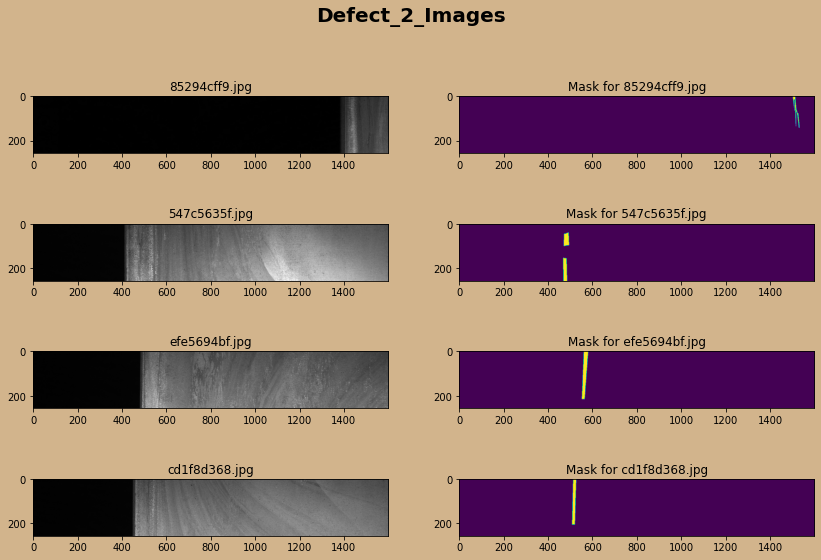

In [ ]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_2']==1]
rle_defect=rle_defect[['image_id','rle_2']]
rle_defect=rle_defect.sample(n=4) 
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,2)

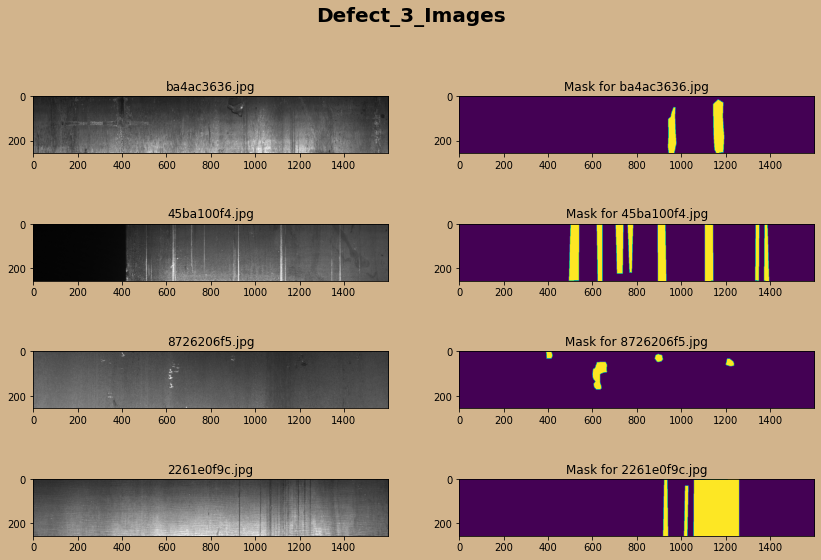

In [ ]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_3']==1]
rle_defect=rle_defect[['image_id','rle_3']]
rle_defect=rle_defect.sample(n=4) 
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,3)

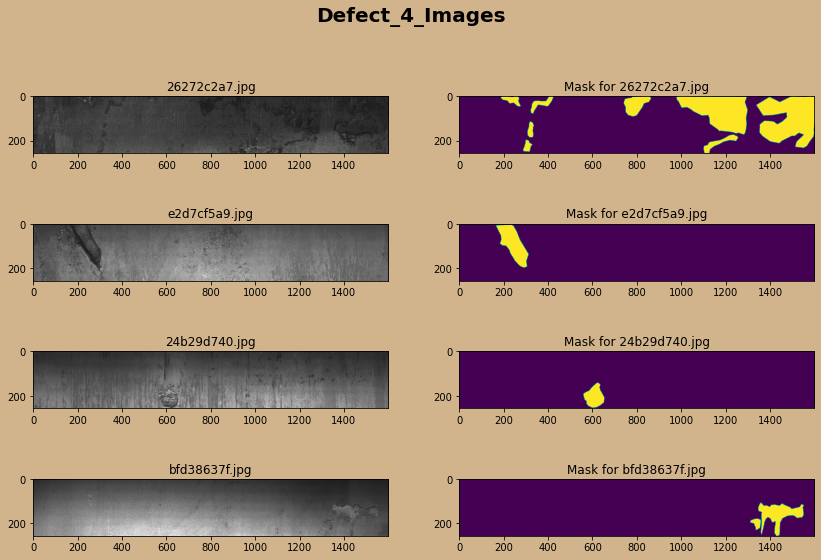

In [ ]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_4']==1]
rle_defect=rle_defect[['image_id','rle_4']]
rle_defect=rle_defect.sample(n=4) 
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,4)

In [ ]:
def mask_areas(rle_defect):
  area=[]
  for i in rle_defect:
    mask=np.sum(rle_to_mask(i))
    area.append(np.sum(rle_to_mask(i)))
  return area

In [ ]:
rle_defect=train[train['defect_1']==1]
rle_defect=rle_defect['rle_1']
rle_1_area=mask_areas(rle_defect)

rle_defect=train[train['defect_2']==1]
rle_defect=rle_defect['rle_2']
rle_2_area=mask_areas(rle_defect)

rle_defect=train[train['defect_3']==1]
rle_defect=rle_defect['rle_3']
rle_3_area=mask_areas(rle_defect)

rle_defect=train[train['defect_4']==1]
rle_defect=rle_defect['rle_4']
rle_4_area=mask_areas(rle_defect)

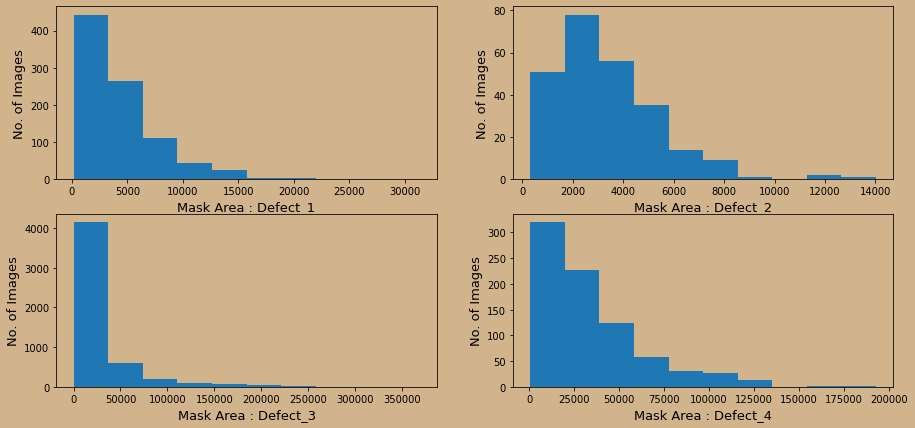

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(15,7))

ax[0,0].hist(x=rle_1_area)
ax[0,0].set_xlabel("Mask Area : Defect_1",fontsize=13)
ax[0,0].set_ylabel("No. of Images",fontsize=13)
ax[0,0].set_facecolor("tan")

ax[0,1].hist(x=rle_2_area)
ax[0,1].set_xlabel("Mask Area : Defect_2",fontsize=13)
ax[0,1].set_ylabel("No. of Images",fontsize=13)
ax[0,1].set_facecolor("tan")

ax[1,0].hist(x=rle_3_area)
ax[1,0].set_xlabel("Mask Area : Defect_3",fontsize=13)
ax[1,0].set_ylabel("No. of Images",fontsize=13)
ax[1,0].set_facecolor("tan")

ax[1,1].hist(x=rle_4_area)
ax[1,1].set_xlabel("Mask Area : Defect_4",fontsize=13)
ax[1,1].set_ylabel("No. of Images",fontsize=13)
ax[1,1].set_facecolor("tan")

fig.set_facecolor("tan")
plt.show()

* Mask area for each defect will help to decide area thresholds during segment prediction (later at the time of modelling).

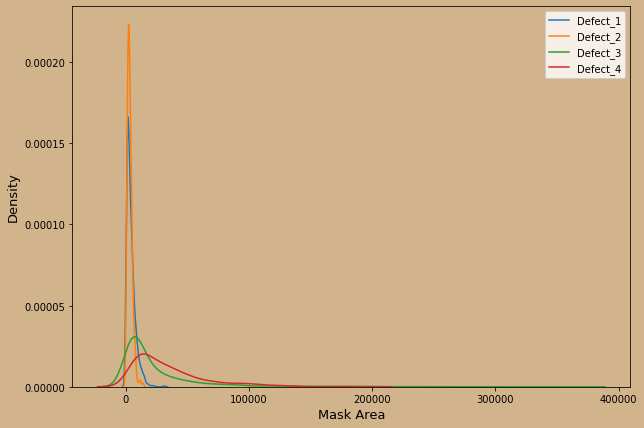

In [ ]:
fig,ax=plt.subplots(figsize=(10,7))

sns.kdeplot(rle_1_area,label='Defect_1')
sns.kdeplot(rle_2_area,label='Defect_2')
sns.kdeplot(rle_3_area,label='Defect_3')
sns.kdeplot(rle_4_area,label='Defect_4')
plt.legend()
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.ylabel('Density',fontsize=13)
plt.xlabel('Mask Area',fontsize=13)
plt.show()

* Masks with large areas seem very suspicious to me, so I will try to plot few images with large mask areas picked by random index

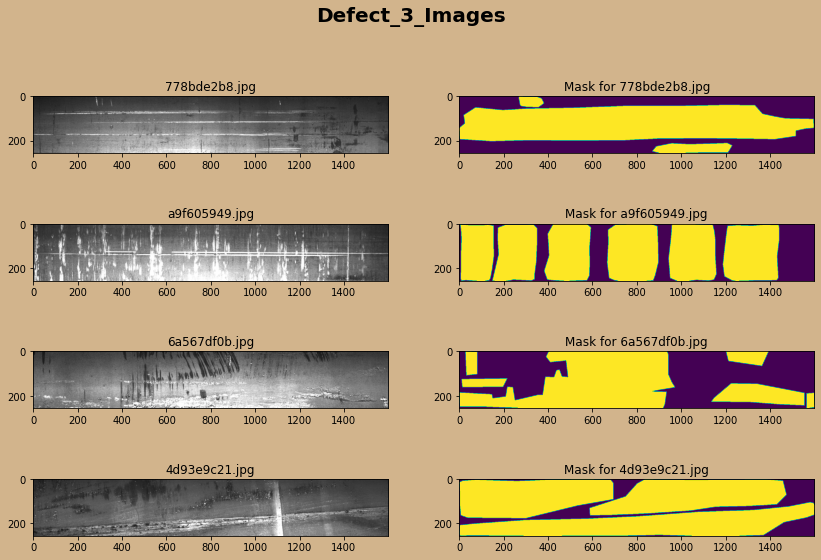

In [ ]:
rle_defect=train[train['defect_3']==1]
rle=rle_defect['rle_3']
rle_3_area=mask_areas(rle)
rle_defect['rle_3_area']=rle_3_area
rle_defect=rle_defect[rle_defect['rle_3_area']>200000]
rle_defect=rle_defect[['image_id','rle_3']]
rle_defect=rle_defect.sample(n=4) 
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,3)

* Large masks seem to be okay except for the fact that these masks seem to contain a lot of empty space without any defects